<a href="https://colab.research.google.com/github/CollinRassel/TechPoint/blob/main/TechPointWSA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install pyspark

In [2]:
from pyspark.sql import SparkSession
import pyspark.sql.functions as F
import numpy as np
from math import sqrt
import matplotlib.pyplot as plt
from pyspark.sql.functions import *
import random as rn
from pyspark.sql.functions import when
import datetime
from datetime import timedelta, time

In [3]:
spark = SparkSession.builder\
        .master('local')\
        .appName('Colab')\
        .config('spark.ui.port','4050')\
        .getOrCreate()

In [4]:
data = spark.read.csv('/content/TechPointData.csv', header=True)
data = data.withColumn('Type', rtrim(data.Type))

In [5]:
activities = {'Museum':5, 'Sport':3, 'Outdoor':2.5, 'Amusement':4, 'Shopping':2, 'Drink':1, 'Entertainment':3}

In [6]:
def time_change(start, change):
    return start + change

In [11]:
user_input = input('Welcome to the Indianapolis Day Trip Planner!\nPlease select how you would like to organize your itenerary!\n\tA - Highest Rating\n\tB - Rating Threshold\n\tC - Exit Program\n')
while user_input != 'C' or user_input != 'c':
  if user_input == 'A' or user_input == 'a':
    activities_select = data.where(~F.col('Type').contains('food')).orderBy(F.col('Rating').desc())
    eating = data.where(F.col('Type').contains('food')).orderBy(F.col('Rating').desc())

    curr_time = 9
    itenerary_test = []
    meals = ['breakfast','lunch','dinner']
    num_meals = []
    names_for_test = []
    print('\nYour Itenerary: \n')
    for count, meal in enumerate(meals, start=1):
      meal_sort = eating.where(F.col('Type').contains(meal) & ~F.col('Name').isin(names_for_test)).orderBy(F.col('Rating').desc()) # filter dataframe to show all breakfast spots, sorted by rating 
      rating = meal_sort.select(F.col('Rating')).head(1)[0][0] # get the highest rating for breakfast restaurants
      spots = meal_sort.where(F.col('Rating').contains(rating)).collect() # send all the restaurants that qualify to a list
      choice = rn.choice(spots)
      itenerary_test.append(choice)
      num_meals.append(choice)
      names_for_test.append(choice[0]) # this is to make sure the same restaurant does not get selected twice
      if count == 1:
        if curr_time % 1 != 0:
          print(str(int(curr_time//1)) + ':30' + ':'.rjust(3 - len(str(curr_time))) + ' ' + choice['Name'] + ', ' + choice['Address'] + ', ' + 'breakfast, for ' + str(1.5) + ' hours')
        else:
          print(str(int(curr_time)) + ':00' + ':'.rjust(3 - len(str(curr_time))) + ' ' + choice['Name'] + ', ' + choice['Address'] + ', ' + 'breakfast, for ' + str(1.5) + ' hours')
      elif count == 2: 
        if curr_time % 1 != 0:
          print(str(int(curr_time//1)) + ':30' + ':'.rjust(3 - len(str(curr_time))) + ' ' + choice['Name'] + ', ' + choice['Address'] + ', ' + 'lunch, for ' + str(1.5) + ' hours')
        else:
          print(str(int(curr_time)) + ':00' + ':'.rjust(3 - len(str(curr_time))) + ' ' + choice['Name'] + ', ' + choice['Address'] + ', ' + 'lunch, for ' + str(1.5) + ' hours')
      elif count == 3: 
        if curr_time % 1 != 0:
          print(str(int(curr_time//1)) + ':30' + ':'.rjust(3 - len(str(curr_time))) + ' ' + choice['Name'] + ', ' + choice['Address'] + ', ' + 'dinner, for ' + str(1.5) + ' hours')
        else:
          print(str(int(curr_time)) + ':00' + ':'.rjust(3 - len(str(curr_time))) + ' ' + choice['Name'] + ', ' + choice['Address'] + ', ' + 'dinner, for ' + str(1.5) + ' hours')
      curr_time = time_change(curr_time, 1.5)
      for row in activities_select.collect():
        
        if len(num_meals) == 1 and row['Type'] == 'Museum': # we do not have time to visit a museum in the morning, if we have only gone to breakfast, skip any museum options
          continue

        else:
          if row['Name'] not in names_for_test: # if an activity is already in the itenerary, do not put it in again 
            itenerary_test.append(row)
            names_for_test.append(row['Name'])
            if curr_time % 1 != 0:
              print(str(int(curr_time//1)) + ':30' + ':'.rjust(3 - len(str(curr_time))) + ' ' + row['Name'] + ', ' + row['Address'] + ', ' + row['Type'] + ' for ' + str(activities[row['Type']]) + ' hours')
            else:
              print(str(int(curr_time)) + ':00' + ':'.rjust(3 - len(str(curr_time))) + ' ' + row['Name'] + ', ' + row['Address'] + ', ' + row['Type'] + ' for ' + str(activities[row['Type']]) + ' hours')

            curr_time = time_change(curr_time, activities[row['Type']])
            
            
          else: # skip to the next option if item is already in itenerary 
            continue

          if (curr_time >= 11 and curr_time <= 13) or curr_time >= 18: #may have to tinker with this statement here, it is attempting to break out of activities when it is meal time 
            break
      
      if curr_time >= 21:
        user_input = 'c'
        break

  elif user_input == 'B' or user_input == 'b':
    rating_thresh = input('Please input your desired minimum rating:\n')
    activities_select = data.where(~F.col('Type').contains('food') & (F.col('Rating') >= rating_thresh))
    #activities_select = activities_select.where(F.col('Rating') >= rating_thresh)
    activities_select = activities_select.select("*").orderBy(F.rand())
    eating = data.where(F.col('Type').contains('food') & (F.col('Rating') >= rating_thresh))
    eating = eating.select("*").orderBy(F.rand())

    curr_time = 9
    itenerary_test = []
    meals = ['breakfast','lunch','dinner']
    num_meals = []
    names_for_test = []
    print('\nYour Itenerary: \n')
    for count, meal in enumerate(meals, start=1):
      meal_spots = eating.where(F.col('Type').contains(meal) & ~F.col('Name').isin(names_for_test)).collect() # filter dataframe to show all certain meal spots that are above the threshold 
      choice = rn.choice(meal_spots)
      itenerary_test.append(choice)
      num_meals.append(choice)
      names_for_test.append(choice[0]) # this is to make sure the same restaurant does not get selected twice
      if count == 1:
        if curr_time % 1 != 0:
          print(str(int(curr_time//1)) + ':30' + ':'.rjust(3 - len(str(curr_time))) + ' ' + choice['Name'] + ', ' + choice['Address'] + ', ' + 'breakfast, for ' + str(1.5) + ' hours')
        else:
          print(str(int(curr_time)) + ':00' + ':'.rjust(3 - len(str(curr_time))) + ' ' + choice['Name'] + ', ' + choice['Address'] + ', ' + 'breakfast, for ' + str(1.5) + ' hours')
      elif count == 2: 
        if curr_time % 1 != 0:
          print(str(int(curr_time//1)) + ':30' + ':'.rjust(3 - len(str(curr_time))) + ' ' + choice['Name'] + ', ' + choice['Address'] + ', ' + 'lunch, for ' + str(1.5) + ' hours')
        else:
          print(str(int(curr_time)) + ':00' + ':'.rjust(3 - len(str(curr_time))) + ' ' + choice['Name'] + ', ' + choice['Address'] + ', ' + 'lunch, for ' + str(1.5) + ' hours')
      elif count == 3: 
        if curr_time % 1 != 0:
          print(str(int(curr_time//1)) + ':30' + ':'.rjust(3 - len(str(curr_time))) + ' ' + choice['Name'] + ', ' + choice['Address'] + ', ' + 'dinner, for ' + str(1.5) + ' hours')
        else:
          print(str(int(curr_time)) + ':00' + ':'.rjust(3 - len(str(curr_time))) + ' ' + choice['Name'] + ', ' + choice['Address'] + ', ' + 'dinner, for ' + str(1.5) + ' hours')
      curr_time = time_change(curr_time, 1.5)
      for row in activities_select.collect():
        
        if len(num_meals) == 1 and row['Type'] == 'Museum': # we do not have time to visit a museum in the morning, if we have only gone to breakfast, skip any museum options
          continue

        else:
          if row['Name'] not in names_for_test: # if an activity is already in the itenerary, do not put it in again 
            itenerary_test.append(row)
            names_for_test.append(row['Name'])
            if curr_time % 1 != 0:
              print(str(int(curr_time//1)) + ':30' + ':'.rjust(3 - len(str(curr_time))) + ' ' + row['Name'] + ', ' + row['Address'] + ', ' + row['Type'] + ' for ' + str(activities[row['Type']]) + ' hours')
            else:
              print(str(int(curr_time)) + ':00' + ':'.rjust(3 - len(str(curr_time))) + ' ' + row['Name'] + ', ' + row['Address'] + ', ' + row['Type'] + ' for ' + str(activities[row['Type']]) + ' hours')

            curr_time = time_change(curr_time, activities[row['Type']])
            
            
          else: # skip to the next option if item is already in itenerary 
            continue

          if (curr_time >= 11 and curr_time <= 13) or curr_time >= 18: #may have to tinker with this statement here, it is attempting to break out of activities when it is meal time 
            break
      
      if curr_time >= 21:
        user_input = 'c'
        break

  elif user_input == 'C' or user_input == 'c':
    print('\nGoodbye!')
    break
  else:
    print('Error: Please enter a valid input (A or B)\n')
    user_input = input('Please select how you would like to organize your itenerary!\n\tA - Highest Rating\n\tB - Rating Threshold\n\tC - Exit Program\n')




Welcome to the Indianapolis Day Trip Planner!
Please select how you would like to organize your itenerary!
	A - Highest Rating
	B - Rating Threshold
	C - Exit Program
b
Please input your desired minimum rating:
4.5

Your Itenerary: 

9:00 : Gallery Pastry Bar, 110 S Pennsylvania St Suite B, Indianapolis, IN 46204, breakfast, for 1.5 hours
10:30: Centerpoint Brewing, 1125 E Brookside Ave Suite 2B, Indianapolis, IN 46202, Drink for 1 hours
11:30: Shapiro's Delicatessen, 808 S Meridian St, Indianapolis, IN 46225, lunch, for 1.5 hours
13:00: The Cabaret, 924 N Pennsylvania St Suite B, Indianapolis, IN 46204, Entertainment for 3 hours
16:00: Broad Ripple Park, 1500 Broad Ripple Ave, Indianapolis, IN 46220, Outdoor for 2.5 hours
18:30: Metro Diner, 7225 US-31 Unit A06, Indianapolis, IN 46227, dinner, for 1.5 hours
20:00: Hinkle Fieldhouse, 510 W 49th St, Indianapolis, IN 46208, Sport for 3 hours

Goodbye!


Text(0, 0.5, 'Number of Attractions')

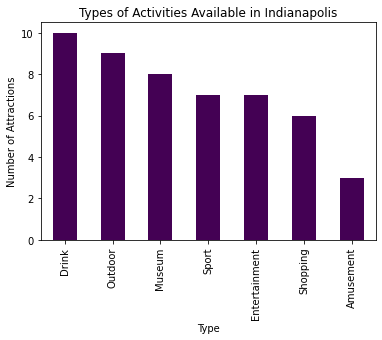

In [61]:
for_viz = data.toPandas()
new_df = for_viz[~for_viz["Type"].str.contains('food')]
new_df['Type'].value_counts().plot(kind='bar', colormap='viridis')
amusement_counts = new_df['Type'].value_counts().sum()
plt.title('Types of Activities Available in Indianapolis')
plt.xlabel('Type')
plt.ylabel('Number of Attractions')

Text(0.5, 1.0, 'How Many Places Can I get Different Meals?')

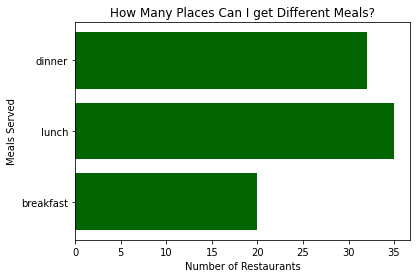

In [55]:
for_viz = data.toPandas()
meals = ['breakfast','lunch','dinner']
counts = []
for meal in meals:
  meal_df = for_viz[for_viz["Type"].str.contains(meal)]
  df = meal_df['Type'].value_counts().rename_axis('food_type').reset_index(name='counts')
  counts.append(df['counts'].sum())

plt.barh(meals,counts, align='center', color='darkgreen', label="Data 1")
plt.xlabel('Number of Restaurants')
plt.ylabel('Meals Served')
plt.title('How Many Places Can I get Different Meals?')

# Conclusions

In terms of food, it is easiest to find a place to go get lunch in Indianapolis. This is to be expected given that most restaurants serve two meals, either breakfast and lunch or lunch and dinner. Not many places seem to serve breakfast and dinner. When looking at things to do outside of getting food, getting drinks is a popular option. This finding is somewhat surprising to me, but it makes sense upon consideration. With the rise in popularity of local breweries the number of places to go grab a pint is steadily increasing. Furthermore, I was somewhat surprised to see so many outdoor options for activities in Indianapolis. When I think of Indy, I think of city life and outdoor activities fall to the wayside in my mind. Below you can see the massive number of combinations of restaurants that you can create an itenerary out of if you plan to eat 3 meals in Indianapolis during a day. The dataset used in this project is by no means exhaustive, and it is a testament to the diverse and fascinating breadth of eateries in Indianapolis. Even more exciting is the fact that there are over 100,000 different ways to organize an itenerary of 3 activities in Indianapolis! It is important to note that these findings come with some limitations that are unconsidered including traffic, open and closed days, and limited or special hours for example. With that being said, this data set is only a small slice of all the things that Indianapolis has to offer, an exhaustive list may be well over 500,000 different iteneraries. In conclusion, Indianapolis is a bustling city full of wonderful dining and entertainment opportunities. You can visit Indianapolis every day **for the rest of your life** and never have the same day twice!

In [60]:
eatery_combos = counts[0] * (counts[1]+counts[2]) * (counts[1]+counts[2]-1)
print('There are {} combinations of meal iteneraries if you are eating 3 meals in Indy'.format(eatery_combos))

There are 88440 combinations of meal iteneraries if you are eating 3 meals in Indy


In [64]:
entertainment_combos = amusement_counts * (amusement_counts-1) * (amusement_counts-2)
print('There are {} combinations of activities assuming you are only able to do 3 activities in a day in Indy'.format(entertainment_combos))

There are 117600 combinations of activities assuming you are only able to do 3 activities in a day in Indianapolis
